### Smooth Fano Threefolds with 2-Torus Action

1. Q
2. 2.24
3. 2.29
4. [2.30](#230)
5. [2.31](#231)
6. 2.32
7. [3.8](#38)
8. 3.10
9. [3.18](#318)
10. 3.19
11. 3.20
12. [3.21](#321)
13. [3.22](#322)
14. [3.23](#323)
15. [3.24](#324)
16. 4.4
17. [4.5](#45)
18. 4.7
19. [4.8](#48)

### Helper functions
Some helper functions are defined. These are `degenerations()` for calculating the toric special fibres of the test configurations and `intxexp()` to solve the integrals $\int_\Delta \langle u, v \rangle e^{\langle u, \xi \rangle} du$ analytically.

In [20]:
%display text unicode_art
# The function degenerations:
# Returns the list of degneration polytopes of given combinatorial data of a T-variety. 
# Takes inputs L and B, where L is a list of matrices and B is the base polytope. 
# Each matrix in L represents a piecewise affine function on B in the following way:

#Suppose $v_j$ are the columns of $M$ in the list $L$. We then form the piecewise affine function
# $\phi_M(x_1,\dots,x_n) := \min_j \{ (1,x_1,x_2,\dots,x_n) \cdot v_j \} $.

def degenerations(L,B):
    dim = L[0].nrows()
    genericfunction = matrix(QQ, dim, 1, lambda i, j: 0)
    L = L +[genericfunction]
    def shift(A,r):
        shift = matrix(QQ,  A.transpose().nrows() , 1, lambda i, j: r);
        zeroes = matrix(QQ, A.transpose().nrows(), A.nrows() -1 , lambda i, j: 0);
        return A + shift.augment(zeroes).transpose()
    def minsum(L):
        msCurrent = L[0]
        def minsum_step(A1,A2):
            C = matrix(QQ,A2.nrows(),1,lambda i, j: 0)
            for c in A1.columns():
                for d in A2.columns():
                    C = C.augment(d+c);
            return C.delete_columns([0])
        for l in L[1:]:
            msCurrent = minsum_step(msCurrent,l)
        return msCurrent
    def degenerations_step(L,k,B):
        up = shift(L[k],1)
        base = matrix(QQ, B.inequalities_list()[:]);
        low = L[:]; low.pop(k);
        low = minsum(low).transpose();
        up = up.transpose()
        base = base.augment(matrix(QQ,  base.nrows() , 1, lambda i, j: 0)).transpose()
        up = up.augment(matrix(QQ, up.nrows(), 1, lambda i, j: -1)).transpose()
        low = low.augment(matrix(QQ, low.nrows(), 1, lambda i, j: 1)).transpose()
        low = shift(low,1)
        P = Polyhedron(ieqs = [list(v) for v in up.augment(low.augment(base)).columns()])
        return P;
    Polyhedra = [];
    for k in range(len(L)):
        Polyhedra = Polyhedra + [degenerations_step(L,k,B)];
    return Polyhedra


def projection(P,F):
    A = F.as_polyhedron().equations()[0].A()
    b = F.as_polyhedron().equations()[0].b()
    A = list(A)
    B=vector(QQ,A)
    B=denominator(B)*B
    A = list(B)
    B = matrix(ZZ,B)
    K = B.right_kernel()
    if P.dimension() == 1:
        K= matrix(ZZ,[0])
    else:
        K = matrix(ZZ,K.basis())
    return [K,A]

def acoeff(F,c):
    v_0 = F.vertices()[0].vector(); v_0
    return exp(c.dot_product(v_0))

def bcoeff(F,v):
    u_0 = F.vertices()[0].vector()
    return v.dot_product(u_0)

def relvolume(P):
    if P.dimension() == 0:
        return 1
    else:
        return P.volume()


# The function intexp:
# Calculates the integral of exp(c*x) dx over the polyhedron P recursively using the Barvinok method. Input is a polyhedron P,
# a sufficiently general vector L (not orthogonal, after projection, to c or any face of P at any stage of the recursion),
# and a vector c for the integrand. To optimize performance values obtained at faces are cached along the way.
def intexp(P,L,c,face=None, cache=None):
    if face is None: face = tuple(range(P.n_vertices()))
    if cache is None:
        cache = {}
    if cache.has_key(frozenset(face)):
        return cache[frozenset(face)]
    I = 0
    if c.is_zero():
        cache[face]= relvolume(P)
        return relvolume(P)
    else:
        for F in P.faces(P.dimension() -1):
            ProjMatrix,A = projection(P,F)
            n_F = -F.ambient_Hrepresentation()[0].A()
            n_F = n_F/gcd(n_F)
            coeff = acoeff(F,c)*(1/L.dot_product(c))*(L.dot_product(n_F))
            c_F = ProjMatrix*c
            L_F = ProjMatrix.insert_row(0,vector(ZZ,A)).transpose().solve_right(L)[1:]
            v_0 = F.vertices()[0].vector(); v_0
            Vert = [ProjMatrix.transpose().solve_right(v.vector() - v_0)  for v in F.vertices() ]
            face_F = tuple([face[i] for i in F._ambient_Vrepresentation_indices])
            P_F = Polyhedron(vertices = Vert, backend="cdd")
            I = I + coeff*intexp(P_F,L_F,c_F,face_F,cache)
    cache[frozenset(face)]=I
    return I

# The function intxexp:
# Calculates the integral of <x,v>*exp(<x,c>) dx over the polyhedron P recursively using the Barvinok method. Input is a polyhedron P,
# a sufficiently general vector L (not orthogonal, after projection, to c or any face of P at any stage of the recursion),
# and vectors c and v for the integrand. To optimize performance values obtained at faces are cached along the way.
def intxexp(P,L,c,v,face=None,cache=None,cache2=None):
    if face is None: face = tuple(range(P.n_vertices()))
    if cache2 is None:
        cache2 = {}
    if cache is None:
        cache = {}
    if cache.has_key(frozenset(face)):
        return cache[frozenset(face)] 
    I = 0
    if c.is_zero():
        if v.is_zero() : return 0
        for T in list(P.triangulate()):
            T = [P.Vrepresentation()[ZZ(t)].vector() for t in T]
            bary = sum(T)/len(T)
            T = Polyhedron(vertices = T)
            I = I + T.volume()*bary.dot_product(v)
    else:
        for F in P.faces(P.dimension() -1):
                ProjMatrix = projection(P,F)
                L_F  = ProjMatrix[0].insert_row(0,vector(ZZ,ProjMatrix[1])).transpose().solve_right(L)[1:]
                c_F = ProjMatrix[0]*c
                v_F = ProjMatrix[0]*v
                v_0 = F.vertices()[0].vector(); v_0
                Vert = [ProjMatrix[0].transpose().solve_right(w.vector() - v_0)  for w in F.vertices() ]
                face_F = tuple([face[i] for i in F._ambient_Vrepresentation_indices])
                P_F = Polyhedron(vertices = Vert,backend="cdd")
                n_F = -F.ambient_Hrepresentation()[0].A()
                n_F = n_F/gcd(n_F)
                I = I + (L.dot_product(n_F)/L.dot_product(c))*acoeff(F,c)*(intxexp(P_F,L_F,c_F,v_F,face_F,cache,cache2) + bcoeff(F,v)*intexp(P_F,L_F,c_F,face_F,cache2)) - L.dot_product(n_F)*(v.dot_product(L)/(L.dot_product(c)^2))*acoeff(F,c)*intexp(P_F,L_F,c_F,face_F,cache2)
    cache[frozenset(face)]=I
    return I

---
#### No. 2.30 <a id="230"></a>
The combinatorial data is is given by $\Box= \text{conv} (\, (-3,0),(-2,1),(2,1),(3,0),(0,-3) \, )$ and  $\Phi_0(x,y) = \min \{0,-x\},\; \Phi_1(x,y)=  \min \{0,y\},\; \Phi_\infty(x,y) = \frac{x-y-1}{2}$.

The combinatorial data


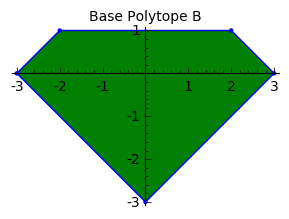

 
Min(0, -x)
 
Min(0, y)
 
x   y   1
─ - ─ - ─
2   2   2


In [9]:
# We are working with interval arithmetic with precision of 16 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-3,0],[-2,1],[2,1],[3,0],[0,-3]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,-1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,1]]).transpose()
Phi3 = matrix(QQ,[[-1/2,1/2,-1/2]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & 0\\ 0 & 1\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, (0,\xi_2) \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (0,\xi_2,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [7]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (0, ((2*xi_2^3 - 3*xi_2 - 3)*e^(4*xi_2) + 12*xi_2*e^(3*xi_2) + 3*xi_2 + 3)*e^(-3*xi_2)/xi_2^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [21]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
lower = 0.514
upper = 0.515

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.513992 .. 0.515015]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every (admissible) choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [22]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 -3⋅ξ₂ ⎛ 4⋅ξ₂ ⎛    3           ⎞      3⋅ξ₂ ⎛    2    ⎞           ⎞        
e     ⋅⎝e    ⋅⎝2⋅ξ₂  - 3⋅ξ₂ - 3⎠ + 3⋅e    ⋅⎝3⋅ξ₂  + 2⎠ - 3⋅ξ₂ - 3⎠        
────────────────────────────────────────────────────────────────── ≥ 1.087
                                  4                                       
                              3⋅ξ₂                                        
 -3⋅ξ₂ ⎛ 4⋅ξ₂ ⎛    3       2    ⎞       3⋅ξ₂ ⎛    2           ⎞             ⎞ 
e     ⋅⎝e    ⋅⎝8⋅ξ₂  + 6⋅ξ₂  - 3⎠ - 12⋅e    ⋅⎝3⋅ξ₂  - 3⋅ξ₂ + 1⎠ + 12⋅ξ₂ + 15⎠ 
───────────────────────────────────────────────────────────────────────────── 
                                        4                                     
                                    6⋅ξ₂                                      

       
       
≥ 2.178
       
       
  -3⋅ξ₂ ⎛   4⋅ξ₂ ⎛    3           ⎞      3⋅ξ₂ ⎛    2            ⎞             
-e     ⋅⎝2⋅e    ⋅⎝2⋅ξ₂  - 3⋅ξ₂ - 3⎠ - 3⋅e    ⋅⎝3⋅ξ₂  - 12⋅ξ₂ + 2⎠ + 12⋅ξ₂ + 12
───────────────────────────────

---
#### No. 2.31 <a id="231"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-3,0),(-1,2),(0,2),(2,0),(2,-1),(0,-3)  \, )$ and  $\Phi_0(x,y) = \min \{0,-x\},\; \Phi_1(x,y)= \min \{0,y\} ,\; \Phi_\infty(x,y) = \min \{-y, \frac{x-y-1}{2} \}$.

The combinatorial data


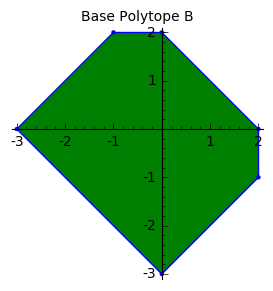

 
Min(0, -x)
 
Min(0, y)
 
Min(-y, x/2 - y/2 - 1/2)


In [23]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(60)

# The base polytope
B=Polyhedron(vertices = [[-3,0],[-1,2],[0,2],[2,0],[2,-1],[0,-3]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,-1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,1]]).transpose()
Phi3 = matrix(QQ,[[-1/2,1/2,-1/2],[0,0,-1]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
 For this note, that $\left(\begin{smallmatrix} 0 & 1\\ 1 & 0\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(\xi_1,\xi_1)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [24]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,-1,0])).simplify_full()
F2(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,1,0])).simplify_full()

show(vector([F1,F2]))

xi_1 |--> (0, -1/2*(9*xi_1^2 - 8*(xi_1^2 - xi_1)*e^(5*xi_1) + (3*xi_1^2 - 5*xi_1 - 3)*e^(4*xi_1) + 9*xi_1 + 3)*e^(-3*xi_1)/xi_1^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [25]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
lower = 0.285497
upper = 0.285507

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.28549700000000000077 .. 0.28550700000000001078]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every (admissible) choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [26]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([xi_2,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 -3⋅ξ₂ ⎛ 4⋅ξ₂ ⎛    2           ⎞        2            ⎞                     
e     ⋅⎝e    ⋅⎝4⋅ξ₂  + 2⋅ξ₂ - 3⎠ + 12⋅ξ₂  + 10⋅ξ₂ + 3⎠                     
────────────────────────────────────────────────────── ≥ 1.9509141924719433
                            4                                              
                        8⋅ξ₂                                               
  -3⋅ξ₂ ⎛      5⋅ξ₂ ⎛  2     ⎞    4⋅ξ₂ ⎛    2            ⎞       2           ⎞
-e     ⋅⎝- 16⋅e    ⋅⎝ξ₂  - ξ₂⎠ + e    ⋅⎝2⋅ξ₂  - 12⋅ξ₂ - 3⎠ + 6⋅ξ₂  + 8⋅ξ₂ + 3⎠
──────────────────────────────────────────────────────────────────────────────
                                         4                                    
                                     8⋅ξ₂                                     

                      
                      
─ ≥ 1.9410579647693612
                      
                      
 -3⋅ξ₂ ⎛   5⋅ξ₂    4⋅ξ₂ ⎛    2           ⎞      3⋅ξ₂       2           ⎞      
e     ⋅⎝4⋅e     - e    ⋅⎝3⋅ξ₂ 

---
#### No. 3.8*<a id="38"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-2,-1),(-2,1),(1,1),(3,-1),(3,-2),(-1,-2)  \, )$ and  $\Phi_0(x,y) = \min \{0,\frac{-x-1}{2}\},\; \Phi_1(x,y)=  \min \{0,\frac{-y-1}{2}\} ,\; \Phi_\infty(x,y) = \min \{0, \frac{x+y-1}{2}\}$.

The combinatorial data


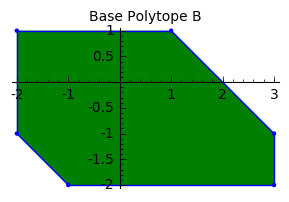

 
Min(0, -x/2 - 1/2)
 
Min(0, -y/2 - 1/2)
 
Min(0, x/2 + y/2 - 1/2)


In [27]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(60)

# The base polytope
B=Polyhedron(vertices = [[-2,-1],[-2,1],[1,1],[3,-1],[3,-2],[-1,-2]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[-1/2,-1/2,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[-1/2,0,-1/2]]).transpose()
Phi3 = matrix(QQ,[[0,0,0],[-1/2,1/2,1/2]]).transpose();


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & -1\\ 0 & 1\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [28]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,5,13])

# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (-1/4*((2*xi_2^2 - xi_2 - 2)*e^(3*xi_2) + 5*(xi_2 + 2)*e^xi_2 - 8*xi_2 - 8)*e^(-2*xi_2)/xi_2^3, 1/2*((2*xi_2^2 - xi_2 - 2)*e^(3*xi_2) + 5*(xi_2 + 2)*e^xi_2 - 8*xi_2 - 8)*e^(-2*xi_2)/xi_2^3)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [29]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
find_root(F2,-10,10)

lower = 0.799716
upper = 0.799717

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.79971599999999998242 .. 0.79971700000000001119]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [30]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 -ξ₂ ⎛ 2⋅ξ₂ ⎛    2    ⎞           ⎞                      
e   ⋅⎝e    ⋅⎝2⋅ξ₂  - 1⎠ + 2⋅ξ₂ + 1⎠                      
─────────────────────────────────── ≥ 0.87460114755231644
                   3                                     
               4⋅ξ₂                                      
 -2⋅ξ₂ ⎛   3⋅ξ₂ ⎛    3       2        ⎞      ξ₂ ⎛     2           ⎞        2  
e     ⋅⎝- e    ⋅⎝5⋅ξ₂  - 9⋅ξ₂  - 12⋅ξ₂⎠ - 6⋅e  ⋅⎝10⋅ξ₂  + 5⋅ξ₂ + 1⎠ + 48⋅ξ₂  +
──────────────────────────────────────────────────────────────────────────────
                                               4                              
                                          24⋅ξ₂                               

          ⎞                      
 24⋅ξ₂ + 6⎠                      
─────────── ≥ 0.92008662275004536
                                 
                                 
 -ξ₂ ⎛ 2⋅ξ₂ ⎛    2    ⎞           ⎞                      
e   ⋅⎝e    ⋅⎝2⋅ξ₂  - 1⎠ + 2⋅ξ₂ + 1⎠                      
────────────────────────────

---
#### No. 3.18 <a id="318"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-3,0),(-2,1),(2,1),(3,0),(1,-2),(-1,-2)  \, )$ and  $\Phi_0(x,y) = \min \{0,\frac{-x-1}{2},-x\},\; \Phi_1(x,y)= \min \{ 0,y\}  ,\; \Phi_\infty(x,y) = \frac{x-y-1}{2}$.

The combinatorial data


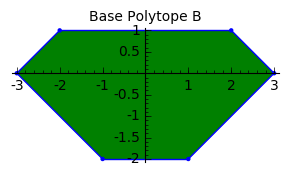

 
Min(0, -x, -x/2 - 1/2)
 
Min(0, y)
 
x   y   1
─ - ─ - ─
2   2   2


In [31]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-3,0],[-2,1],[2,1],[3,0],[1,-2],[-1,-2]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[-1/2,-1/2,0],[0,-1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,1]]).transpose()
Phi3 = matrix(QQ,[[-1/2,1/2,-1/2]]).transpose();


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & 0\\ 0 & 1\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [32]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (0, -1/2*(4*xi_2^2 - (3*xi_2^3 + xi_2^2 - 6*xi_2 - 6)*e^(3*xi_2) - 24*xi_2*e^(2*xi_2) - 6)*e^(-2*xi_2)/xi_2^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [33]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
lower = 0.3796905
upper = 0.3797005

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.379684 .. 0.379708]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every (admissible) choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [34]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 -2⋅ξ₂ ⎛   3⋅ξ₂ ⎛  3           ⎞      2⋅ξ₂ ⎛    2    ⎞       2    ⎞         
e     ⋅⎝2⋅e    ⋅⎝ξ₂  - 3⋅ξ₂ - 3⎠ + 6⋅e    ⋅⎝3⋅ξ₂  + 2⎠ + 3⋅ξ₂  - 6⎠         
─────────────────────────────────────────────────────────────────── ≥ 0.3681
                                   4                                        
                               6⋅ξ₂                                         
  -2⋅ξ₂ ⎛   3⋅ξ₂ ⎛     3        2    ⎞       2⋅ξ₂ ⎛    2           ⎞        2 
-e     ⋅⎝- e    ⋅⎝14⋅ξ₂  + 15⋅ξ₂  - 6⎠ + 24⋅e    ⋅⎝3⋅ξ₂  - 3⋅ξ₂ + 1⎠ + 12⋅ξ₂  
──────────────────────────────────────────────────────────────────────────────
                                                4                             
                                           12⋅ξ₂                              

           ⎞         
+ 6⋅ξ₂ - 30⎠         
───────────── ≥ 2.516
                     
                     
 -2⋅ξ₂ ⎛     3⋅ξ₂ ⎛  3           ⎞      2⋅ξ₂ ⎛  2           ⎞       2     ⎞   
e     ⋅⎝- 2⋅e    ⋅⎝ξ₂  - 3⋅ξ₂ 

---
#### No. 3.21 <a id="321"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-2,1),(-3,3),(-1,3),(1,-2),(3,-3),(3,-1)  \, )$ and  $\Phi_0(x,y) = \min \{0,\frac{-x-1}{2}\},\; \Phi_1(x,y)= \min \{0,\frac{-y-1}{2}\} ,\; \Phi_\infty(x,y) = \min \{0,x+y\} $.

The combinatorial data


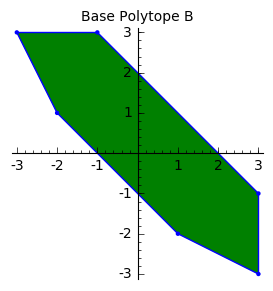

 
Min(0, -x/2 - 1/2)
 
Min(0, -y/2 - 1/2)
 
Min(0, x + y)


In [35]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-2,1],[-3,3],[-1,3],[1,-2],[3,-3],[3,-1]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[-1/2,-1/2,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[-1/2,0,-1/2]]).transpose()
Phi3 = matrix(QQ,[[0,0,0],[0,1,1]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix} 0 & 1\\ 1 & 0\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence we have $\xi=(\xi_1,\xi_1)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [36]:
#Choose a sufficiently general value for Lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,-1,0])).simplify_full()
F2(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,1,0])).simplify_full()

show(vector([F1,F2]))

xi_1 |--> (0, (xi_1^3 - xi_1^2 + 4*(xi_1^2 - xi_1)*e^(3*xi_1) + 6*(2*xi_1 - 1)*e^xi_1 - 2*xi_1 + 6)*e^(-xi_1)/xi_1^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [37]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
find_root(F2,-10,10)
lower = -0.69631193
upper = -0.69621193

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [-0.696320 .. -0.696197]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [38]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([xi_2,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

  -ξ₂ ⎛     ξ₂ ⎛    2           ⎞     3     2           ⎞         
-e   ⋅⎝- 2⋅e  ⋅⎝2⋅ξ₂  - 4⋅ξ₂ + 3⎠ + ξ₂  - ξ₂  - 2⋅ξ₂ + 6⎠         
────────────────────────────────────────────────────────── ≥ 0.691
                              4                                   
                          2⋅ξ₂                                    
  -ξ₂ ⎛     ξ₂ ⎛    2           ⎞     3     2           ⎞         
-e   ⋅⎝- 2⋅e  ⋅⎝2⋅ξ₂  - 4⋅ξ₂ + 3⎠ + ξ₂  - ξ₂  - 2⋅ξ₂ + 6⎠         
────────────────────────────────────────────────────────── ≥ 0.691
                              4                                   
                          2⋅ξ₂                                    
 -ξ₂ ⎛   3⋅ξ₂ ⎛    2           ⎞       ξ₂ ⎛    2           ⎞       3       2  
e   ⋅⎝6⋅e    ⋅⎝8⋅ξ₂  - 4⋅ξ₂ + 1⎠ - 24⋅e  ⋅⎝6⋅ξ₂  - 8⋅ξ₂ + 5⎠ + 5⋅ξ₂  + 9⋅ξ₂  -
──────────────────────────────────────────────────────────────────────────────
                                                4                             
              

---
#### No. 3.22 <a id="322"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-3,-1),(-3,0),(-1,1),(1,1),(3,0),(3,-1)  \, )$ and  $\Phi_0(x,y) = \min \{0,-x\},\; \Phi_1(x,y)= \min \{0,-y\} ,\; \Phi_\infty(x,y) = \frac{x-1}{2} $.

The combinatorial data


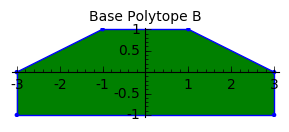

 
Min(0, -x)
 
Min(0, -y)
 
x   1
─ - ─
2   2


In [39]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-3,-1],[-3,0],[-1,1],[1,1],[3,0],[3,-1]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,-1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,-1]]).transpose()
Phi3 = matrix(QQ,[[-1/2,1/2,0]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & 0\\ 0 & 1\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [40]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,5,13])

# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (0, 1/2*(9*xi_2^3 + 9*xi_2^2 + (xi_2^3 + 3*xi_2^2 - 24)*e^(2*xi_2) + 24*(xi_2 + 1)*e^xi_2)*e^(-xi_2)/xi_2^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [41]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
find_root(F2,-10,10)
lower = 0.9147877
upper = 0.9147977

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.914779 .. 0.914811]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [42]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 ξ₂ ⎛  3       2     ⎞       2                      
e  ⋅⎝ξ₂  + 3⋅ξ₂  - 24⎠ + 9⋅ξ₂  + 24⋅ξ₂ + 24         
─────────────────────────────────────────── ≥ 0.8323
                       4                            
                   3⋅ξ₂                             
  -ξ₂ ⎛ 2⋅ξ₂ ⎛  3             ⎞       ξ₂ ⎛    2           ⎞        3⎞         
-e   ⋅⎝e    ⋅⎝ξ₂  - 24⋅ξ₂ - 96⎠ + 24⋅e  ⋅⎝3⋅ξ₂  + 5⋅ξ₂ + 4⎠ + 27⋅ξ₂ ⎠         
────────────────────────────────────────────────────────────────────── ≥ 2.164
                                     4                                        
                                12⋅ξ₂                                         
 ξ₂ ⎛  3       2     ⎞       2                      
e  ⋅⎝ξ₂  + 3⋅ξ₂  - 24⎠ + 9⋅ξ₂  + 24⋅ξ₂ + 24         
─────────────────────────────────────────── ≥ 0.4161
                       4                            
                   6⋅ξ₂                             
  -ξ₂ ⎛   2⋅ξ₂ ⎛    3        2             ⎞      ξ₂ ⎛    2           ⎞    

---
#### No. 3.23 <a id="323"></a>
The combinatorial data is is given by $\Box= \text{conv} (\, (-3,0),(-2,1),(1,1),(2,0),(2,-1), (0,3)\, )$ and  $\Phi_0(x,y) = \min \{0,-x\},\; \Phi_1(x,y)=  \min \{0,y\},\; \Phi_\infty(x,y) = \min \{-y, \frac{x-y-1}{2} \}$.

The combinatorial data


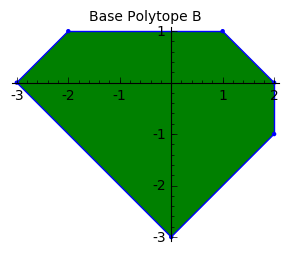

 
Min(0, -x)
 
Min(0, y)
 
Min(-y, x/2 - y/2 - 1/2)


In [43]:
# We are working with interval arithmetic with precision of 40 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(40)

# The base polytope
B=Polyhedron(vertices = [[-3,0],[-2,1],[1,1],[2,0],[2,-1],[0,-3]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,-1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,1]]).transpose()
Phi3 = matrix(QQ,[[-1/2,1/2,-1/2],[0,0,-1]]).transpose()

PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this we have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [44]:
#Choose a sufficiently general value for Lambda
Lambda = vector([3,13,19])

# The integral can be solved symbolically:
F1(xi_1,xi_2) = intxexp(Polyhedra[1],Lambda,vector([xi_1,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_1,xi_2) = intxexp(Polyhedra[1],Lambda,vector([xi_1,xi_2,0]),vector([0,1,0])).simplify_full()

show(F1)
show(F2)

 ⎛    4  3⋅ξ₁     ⎛  3   2  5⋅ξ₁   ⎛  5     4⎞  5⋅ξ₁⎞  2⋅ξ₂     ⎛    3   2  5⋅
-⎝4⋅ξ₁ ⋅ℯ     - 4⋅⎝ξ₁ ⋅ξ₂ ⋅ℯ     - ⎝ξ₁  - ξ₁ ⎠⋅ℯ    ⎠⋅ℯ     + 2⋅⎝2⋅ξ₁ ⋅ξ₂ ⋅ℯ  
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

ξ₁     3 ⎛    2        ⎛    2     ⎞  5⋅ξ₁⎞      ⎛    4       3   ⎛    4       
   + ξ₂ ⋅⎝3⋅ξ₁  + ξ₁ + ⎝2⋅ξ₁  - ξ₁⎠⋅ℯ    ⎠ - ξ₂⋅⎝3⋅ξ₁  + 3⋅ξ₁  + ⎝2⋅ξ₁  - 3⋅ξ₁
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

3⎞  5⋅ξ₁⎞     ⎛  5     4⎞  5⋅ξ₁⎞  3⋅ξ₂   ⎛    4  3⋅ξ₁       4 ⎛          4⋅ξ₁ 
 ⎠⋅ℯ    ⎠ - 2⋅⎝ξ₁  - ξ₁ ⎠⋅ℯ    ⎠⋅ℯ     - ⎝4⋅ξ₁ ⋅ℯ     + 2⋅ξ₂ ⋅⎝(ξ₁ - 2)⋅ℯ     
──────────────────────────────────────────────────

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.
We identify a small closed rectangle containing our estimate such that $ \nabla_n G > 0 $ for any outer normal of this rectangle, where $ G(\xi) = \int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du$. This and uniqueness guarantee our candidate lies within the rectangle.

In [45]:
#numerically finding an estimate
from scipy import optimize

def FF(x):
    return [F1(x[0],x[1]),F2(x[0],x[1])]
sol=optimize.root(FF, [0.2, 0.5])
x0=sol.x

#We hope xi lies in the square with centre x0 and side length 2e, where:
e = 0.00001

xi_RIF=[RIF(x0[0]-e,x0[0]+e), RIF(x0[1]-e,x0[1]+e)]

#We use interval arithmetic to check positivity of $ \nabla_n G $ on the boundary of the square. We check line segments along the boundary of length 2e/N.
N=2300


if all([RIF(F1(x0[0]+e,RIF(x0[1]-e+i*(2*e/N),x0[1]-e+(i+1)*(2*e/N)))) > 0
        for i in range(N)]):
    if all([RIF(-F1(x0[0]-e,RIF(x0[1]-e+i*(2*e/N),x0[1]-e+(i+1)*(2*e/N)))) > 0
            for i in range(N)]):
        if all([RIF(F2(RIF(x0[0]-e+i*(2*e/N),x0[0]-e+(i+1)*(2*e/N)), x0[1]+e)) > 0 for i in range(N)]):
            if all([RIF(-F2(RIF(x0[0]-e+i*(2*e/N),x0[0]-e+(i+1)*(2*e/N)), x0[1]-e)) > 0 for i in range(N)]):
                print "There is a root in"
                print xi_RIF[0].str(style="brackets"),"x",xi_RIF[1].str(style="brackets")

There is a root in
[0.26616785810574 .. 0.26618785810616] x [0.67163062513918 .. 0.67165062513960]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every (admissible) choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [46]:
#storage for the functions h_y and for the values h_y(xi) (as intervals)
Ih=[]

print "lower bounds for DF invariants"
for P in Polyhedra:
    h(xi_1,xi_2) = intxexp(P,Lambda,vector([xi_1,xi_2,0]),vector([0,0,1])).simplify_full()
    DF = RIF(h(*xi_RIF))
    Ih.append(DF)
    print(DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        print("negative upper bounds for DF invariant:")# print upper bound for destablising DF value
        if Ih[0] <= 0: print(Ih[0].upper())
        if Ih[1] <= 0: print(Ih[1].upper())
        if Ih[2] <= 0: print(Ih[2].upper())
        if Ih[3] <= 0: print(Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

lower bounds for DF invariants
1.2766364167
1.8401675879
0.10047916986
3.4443270385
Threefold is stable!


---
#### No. 3.24 <a id="324"></a>
The combinatorial data is is given by $\Box= \text{conv} (\, (-2,0),(-2,1),(1,1),(2,0),(2,-2),(0,-2) \, )$ and  $\Phi_0(x,y) = \min \{0,x\},\; \Phi_1(x,y)= \min \{0,y\}  ,\; \Phi_\infty(x,y) = \min \{0,-x-y\} $.

The combinatorial data


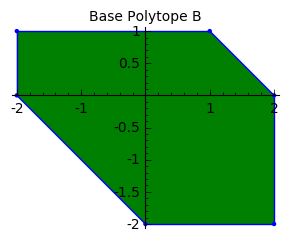

 
Min(0, x)
 
Min(0, y)
 
Min(0, -x - y)


In [47]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-2,0],[-2,1],[1,1],[2,0],[2,-2],[0,-2]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,0,1]]).transpose()
Phi3 = matrix(QQ,[[0,0,0],[0,-1,-1]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & -1 \\ 1 & 0\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [48]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (-((xi_2^2 - 2)*e^(3*xi_2) - 2*xi_2 + 4*e^(2*xi_2) - 2)*e^(-2*xi_2)/xi_2^3, 2*((xi_2^2 - 2)*e^(3*xi_2) - 2*xi_2 + 4*e^(2*xi_2) - 2)*e^(-2*xi_2)/xi_2^3)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [49]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
lower = 0.434747
upper = 0.434757

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.434745 .. 0.434762]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every (admissible) choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [50]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

   -2⋅ξ₂ ⎛ 2⋅ξ₂                  ⎞         
2⋅e     ⋅⎝e    ⋅(ξ₂ - 1) + ξ₂ + 1⎠         
────────────────────────────────── ≥ 0.8781
                 3                         
               ξ₂                          
  -2⋅ξ₂ ⎛   3⋅ξ₂ ⎛    3       2           ⎞       2⋅ξ₂ ⎛    2           ⎞     
-e     ⋅⎝- e    ⋅⎝7⋅ξ₂  + 3⋅ξ₂  - 6⋅ξ₂ + 6⎠ + 12⋅e    ⋅⎝2⋅ξ₂  - 2⋅ξ₂ + 1⎠ + 12
──────────────────────────────────────────────────────────────────────────────
                                                 4                            
                                             6⋅ξ₂                             

   2            ⎞         
⋅ξ₂  + 12⋅ξ₂ - 6⎠         
────────────────── ≥ 1.288
                          
                          
   -2⋅ξ₂ ⎛ 2⋅ξ₂                  ⎞         
2⋅e     ⋅⎝e    ⋅(ξ₂ - 1) + ξ₂ + 1⎠         
────────────────────────────────── ≥ 0.8781
                 3                         
               ξ₂                          
 -2⋅ξ₂ ⎛ 3⋅ξ₂ ⎛    3       2 

---
#### No. 4.5* <a id="45"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-2,1),(-3,3),(-2,3),(1,-2),(3,-3),(3,-2) \, )$ and  $\Phi_0(x,y) = \min \{0,\frac{-x-1}{2}\},\; \Phi_1(x,y)= \min \{0,\frac{-y-1}{2}\}  ,\; \Phi_\infty(x,y) = \min \{0,x+y\} $.

The combinatorial data


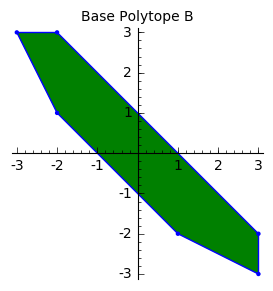

 
Min(0, -x/2 - 1/2)
 
Min(0, -y/2 - 1/2)
 
Min(0, x + y)


In [51]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-2,1],[-3,3],[-2,3],[1,-2],[3,-3],[3,-2]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[-1/2,-1/2,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[-1/2,0,-1/2]]).transpose()
Phi3 = matrix(QQ,[[0,0,0],[0,1,1]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}0 & 1\\ 1 & 0\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence, we have $\xi=(\xi_1,\xi_1)$ We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [52]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,3,13])

# Analytic solution of the integral
F1(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,-1,0])).simplify_full()
F2(xi_1) = intxexp(Polyhedra[0],Lambda,vector([xi_1,xi_1,0]),vector([1,1,0])).simplify_full()

show(vector([F1,F2]))

xi_1 |--> (0, (xi_1^3 - xi_1^2 + 2*(xi_1^3 - 2*xi_1)*e^(2*xi_1) + 6*(2*xi_1 - 1)*e^xi_1 - 2*xi_1 + 6)*e^(-xi_1)/xi_1^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [53]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
find_root(F2,-10,10)
lower = -0.31044
upper = -0.31043

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [-0.310441 .. -0.310424]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [54]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([xi_2,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

  -ξ₂ ⎛     ξ₂ ⎛    2           ⎞     3     2           ⎞          
-e   ⋅⎝- 2⋅e  ⋅⎝2⋅ξ₂  - 4⋅ξ₂ + 3⎠ + ξ₂  - ξ₂  - 2⋅ξ₂ + 6⎠          
────────────────────────────────────────────────────────── ≥ 0.5108
                              4                                    
                          2⋅ξ₂                                     
  -ξ₂ ⎛     ξ₂ ⎛    2           ⎞     3     2           ⎞          
-e   ⋅⎝- 2⋅e  ⋅⎝2⋅ξ₂  - 4⋅ξ₂ + 3⎠ + ξ₂  - ξ₂  - 2⋅ξ₂ + 6⎠          
────────────────────────────────────────────────────────── ≥ 0.5108
                              4                                    
                          2⋅ξ₂                                     
 -ξ₂ ⎛ 2⋅ξ₂ ⎛     3        2            ⎞       ξ₂ ⎛    2           ⎞       3 
e   ⋅⎝e    ⋅⎝37⋅ξ₂  + 27⋅ξ₂  - 18⋅ξ₂ + 6⎠ - 24⋅e  ⋅⎝6⋅ξ₂  - 8⋅ξ₂ + 5⎠ + 5⋅ξ₂  
──────────────────────────────────────────────────────────────────────────────
                                                    4                         
    

---
#### No. 4.8
<a id="48"></a>
The combinatorial data is is given by $\Box= \text{conv} (\,(-2,0),(-1,1),(1,1),(2,0),(2,-1),(-2,-1) \, )$ and  $\Phi_0(x,y) = \min \{0,x\},\; \Phi_1(x,y)= \min \{0,-x\} ,\; \Phi_\infty(x,y) = \min \{0,-y\}$.

The combinatorial data


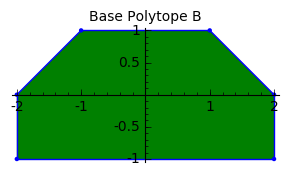

 
Min(0, x)
 
Min(0, -x)
 
Min(0, -y)


In [55]:
# We are working with interval arithmetic with precision of 60 bit
# this fixes the precision e.g. for evaluations of exponential functions
RIF=RealIntervalField(16)

# The base polytope
B=Polyhedron(vertices = [[-2,0],[-1,1],[1,1],[2,0],[2,-1],[-2,-1]])

# 3 PL functions on B. If phi is the minimum of affine functions of the form F(x,y) = a + b*x + c*y we represent phi as
# the transpose of the matrix with rows [a,b,c].

Phi1 = matrix(QQ,[[0,0,0],[0,1,0]]).transpose()
Phi2 = matrix(QQ,[[0,0,0],[0,-1,0]]).transpose()
Phi3 = matrix(QQ,[[0,0,0],[0,0,-1]]).transpose()


PLfunctions = [Phi1,Phi2,Phi3]

# Form list of degeneration polyhedra
Polyhedra = degenerations(PLfunctions,B)



print "The combinatorial data"


graphic = B.plot().show(figsize=[3,3],title='Base Polytope B')

x,y = var('x,y')
r = vector([1,x,y])

for Phi in PLfunctions:
    if Phi.transpose().nrows() > 1:
        f(x,y) = min_symbolic(*list(r*Phi))
    else:
        f(x,y) = list(r*Phi)[0]
    print ' '
    show(f)

#### Step (i) -- obtain a closed form for $F_{X,\xi}$
For this note, that $\left(\begin{smallmatrix}-1 & 0\\ 0 & 1\end{smallmatrix}\right)$ is a symmetry of the combinatorial data. Hence we have $\xi=(0,\xi_2)$. We have to analytically solve the integral $$\int_\Box \langle u,v \rangle \deg \bar \Phi (u) e^{\langle u, \xi \rangle } du = \int_{\Delta_0} \langle u', (v,0) \rangle \cdot e^{\langle u', (\xi,0) \rangle} du'$$ for $v$ varying over a basis of $N_\mathbb{R}$.


In [56]:
#Choose a sufficiently general value for lambda
Lambda = vector([1,5,13])


# Analytic solution of the integral
F1(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([1,0,0])).simplify_full()
F2(xi_2) = intxexp(Polyhedra[0],Lambda,vector([0,xi_2,0]),vector([0,1,0])).simplify_full()

show(vector([F1,F2]))

xi_2 |--> (0, (4*xi_2^3 + 4*xi_2^2 + (xi_2^3 + xi_2^2 - 2*xi_2 - 6)*e^(2*xi_2) + 2*(4*xi_2 + 3)*e^xi_2)*e^(-xi_2)/xi_2^4)

#### Step (ii) -- find an estimate for the soliton candidate vector field $\xi$.

In [57]:
# Choose upper and lower bound and
# hope that the exact solution lies in between
lower = 0.62430
upper = 0.62431

#define a real value xi_RIF between xi_1 and xi_2
# representing the exact solution.
xi_RIF = RIF(lower,upper)

# Check whether Intermediate value theorem guarantees a zero beween
# lower and upper, i.e evaluate F2 at lower and upper using interval arithmetic.
if RIF(F2(lower)) < 0 and RIF(F2(upper)) > 0:
       print "Interval containing solution:", xi_RIF.str(style='brackets')

Interval containing solution: [0.624298 .. 0.624314]


#### Step (iii) & (iv) -- obtain closed forms for $\operatorname{DF}_\xi(X_{y,0,1})$ and plug in the estimate for $\xi$
For this we first have to symbolically solve the integrals  
$$h_y(\xi) := \text{vol}(\Delta_y) \cdot \operatorname{DF}_\xi(\mathcal{X}_{y,0,1})=\int_{\Delta_y}  \langle u, (0,0,1) \, \rangle e^{\langle u, (\xi,0) \rangle }  \; du$$  
for every choice of $y \in \mathbb P^1$ and then plug in the estimate for $\xi$ into the resulting expression.

In [58]:
#storage for the functions h_y
H=[]
#storage for values h_y(xi) (as intervals)
Ih=[]

#Symbollically solving integrals using Barvinok method
for P in Polyhedra:
    h(xi_2) = intxexp(P,Lambda,vector([0,xi_2,0]),vector([0,0,1])).simplify_full()
    DF=RIF(h(xi_RIF))
    H.append(h); Ih.append(DF)
    show(h(xi_2) >= DF.lower())

if all([h > 0 for h in Ih]): 
    print("Threefold is stable!")
else:
    if any([h <= 0 for h in Ih]):
        print("Threefold is not stable!")

        # print upper bound for destablising DF value
        if Ih[0] <= 0: show(H[0](xi_2) <= Ih[0].upper())
        if Ih[1] <= 0: show(H[1](xi_2) <= Ih[1].upper())
        if Ih[2] <= 0: show(H[2](xi_2) <= Ih[2].upper())
        if Ih[3] <= 0: show(H[3](xi_2) <= Ih[3].upper())
    else:
        print("Cannot determine stability")
        # Note, that "not a > 0" does not imply "a <= 0" for intervals

 ξ₂ ⎛  3     2           ⎞       2                    
e  ⋅⎝ξ₂  + ξ₂  - 2⋅ξ₂ - 6⎠ + 4⋅ξ₂  + 8⋅ξ₂ + 6         
───────────────────────────────────────────── ≥ 0.6641
                        4                             
                    2⋅ξ₂                              
 ξ₂ ⎛  3     2           ⎞       2                    
e  ⋅⎝ξ₂  + ξ₂  - 2⋅ξ₂ - 6⎠ + 4⋅ξ₂  + 8⋅ξ₂ + 6         
───────────────────────────────────────────── ≥ 0.6641
                        4                             
                    2⋅ξ₂                              
  -ξ₂ ⎛ 2⋅ξ₂ ⎛  3            ⎞      ξ₂ ⎛    2           ⎞       3⎞         
-e   ⋅⎝e    ⋅⎝ξ₂  - 6⋅ξ₂ - 12⎠ + 6⋅e  ⋅⎝2⋅ξ₂  + 3⋅ξ₂ + 2⎠ + 4⋅ξ₂ ⎠         
─────────────────────────────────────────────────────────────────── ≥ 1.103
                                   4                                       
                               3⋅ξ₂                                        
  -ξ₂ ⎛   2⋅ξ₂ ⎛    3       2    ⎞      ξ₂                3⎞         
